# NJA-CFS Tutorial - Basic Usage
## Not Just Another Crystal Field Software

This notebook demonstrates basic usage of NJA-CFS for crystal field/ligand field calculations on d^n and f^n systems.

## 1. Import the module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nja_cfs_red as nja

# The program info will print automatically on import



************************************************************
   NJA-CFS (Not Just Another - Crystal Field Software)
   Version: 1.2.0
   Date: October 07, 2025
************************************************************




c:\Users\Timur\Documents\Python_Scripts\crystal-hub\raw_packages\NJA-CFS\nja_cfs_red.py:2110: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(complex128, 2, 'A', False, aligned=True), Array(complex128, 1, 'C', False, aligned=True))
  mu_single = np.dot(np.conj(np.ascontiguousarray(result[1:, ii]).T), np.dot(mu_matrix[kk, ...], np.ascontiguousarray(result[1:, ii])))


## 2. Example 1: Simple f^7 calculation (Gd³⁺, Tb³⁺)
### Free ion calculation with electron-electron repulsion and spin-orbit coupling

In [2]:
# Create calculation object for f^7 configuration
# ground_only=True means we only consider the ground multiplet (⁸S for f^7)
# TAB=True means use pre-calculated tables for reduced matrix elements
calc = nja.calculation('f7', ground_only=True, TAB=True, wordy=True)

print(f"\nBasis set size: {calc.basis.shape[0]}")
print(f"Configuration: {calc.conf}")


Configuration: f7
Number of microstates: 3432
Ground state only calculation
Basis set reduced to: 8

Basis set size: 8
Configuration: f7


In [3]:
# Get free ion parameters (Hartree-Fock values)
params = nja.free_ion_param_f_HF('f7')
print("\nFree ion parameters (cm⁻¹):")
print(f"F² = {params['F2']:.1f}")
print(f"F⁴ = {params['F4']:.1f}")
print(f"F⁶ = {params['F6']:.1f}")
print(f"ζ  = {params['zeta']:.1f}")


Free ion parameters (cm⁻¹):
F² = 114742.0
F⁴ = 71865.0
F⁶ = 51662.0
ζ  = 1561.0


In [4]:
# Run calculation with electron-electron repulsion and spin-orbit coupling
result = calc.MatrixH(
    ['Hee', 'Hso'],  # Include e-e repulsion and SOC
    F2=params['F2'],
    F4=params['F4'],
    F6=params['F6'],
    zeta=params['zeta'],
    wordy=True
)

# Result format: first row = eigenvalues, remaining rows = eigenvectors
energies = result[0, :].real
print(f"\nGround state energy: {energies[0]:.3f} cm⁻¹")
print(f"Energy range: {energies[-1] - energies[0]:.3f} cm⁻¹")


Performing calculation with the following contributions: 
['Hee', 'Hso']
Calculation result: 
E0: 38409738.309
      0.000 (8)

Ground state energy: 38409738.309 cm⁻¹
Energy range: 0.000 cm⁻¹


## 3. Example 2: Crystal Field Calculation
### Point charge model for a coordination environment

In [5]:
# Create ligand coordinates manually (octahedral environment)
# Format: label, x, y, z, charge
# Metal center at origin, ligands at ±2 Å along axes
ligand_data = np.array([
    ['O', 2.0, 0.0, 0.0, -2.0],    # O²⁻ at +x
    ['O', -2.0, 0.0, 0.0, -2.0],   # O²⁻ at -x
    ['O', 0.0, 2.0, 0.0, -2.0],    # O²⁻ at +y
    ['O', 0.0, -2.0, 0.0, -2.0],   # O²⁻ at -y
    ['O', 0.0, 0.0, 2.0, -2.0],    # O²⁻ at +z
    ['O', 0.0, 0.0, -2.0, -2.0],   # O²⁻ at -z
], dtype=object)

print("Ligand environment (octahedral):")
print("Label    x      y      z    charge")
for row in ligand_data:
    print(f"{row[0]:5s} {float(row[1]):6.2f} {float(row[2]):6.2f} {float(row[3]):6.2f}  {float(row[4]):6.2f}")

Ligand environment (octahedral):
Label    x      y      z    charge
O       2.00   0.00   0.00   -2.00
O      -2.00   0.00   0.00   -2.00
O       0.00   2.00   0.00   -2.00
O       0.00  -2.00   0.00   -2.00
O       0.00   0.00   2.00   -2.00
O       0.00   0.00  -2.00   -2.00


In [6]:
# Calculate crystal field parameters using point charge model
# This calculates Bₖᵍ parameters in Wybourne notation
dic_bkq = nja.calc_Bkq(
    ligand_data,
    'f7',
    sph_flag=False,      # Coordinates are Cartesian (not spherical)
    sth_param=False      # Don't use Sternheimer shielding
)

print("\nCrystal field parameters Bₖᵍ (cm⁻¹):")
for k in sorted(dic_bkq.keys(), key=int):
    print(f"\nk = {k}:")
    for q in sorted(dic_bkq[k].keys(), key=lambda x: int(x)):
        value = dic_bkq[k][q]
        if abs(value) > 1e-6:
            print(f"  B{k}{q:>2s} = {value:10.4f}")


Crystal field parameters Bₖᵍ (cm⁻¹):

k = 2:

k = 4:
  B4 0 = -4743.4858
  B4 4 = -2834.7750

k = 6:
  B6 0 =  -399.2825
  B6 4 =   746.9891


In [7]:
# Run full calculation including crystal field
calc_cf = nja.calculation('f7', ground_only=True, TAB=True, wordy=False)

result_cf = calc_cf.MatrixH(
    ['Hee', 'Hso', 'Hcf'],  # Add crystal field
    F2=params['F2'],
    F4=params['F4'],
    F6=params['F6'],
    zeta=params['zeta'],
    dic_bkq=dic_bkq,
    wordy=True
)

energies_cf = result_cf[0, :].real
energies_cf_rel = energies_cf - energies_cf[0]

print(f"\nCrystal field splitting: {energies_cf_rel[-1]:.3f} cm⁻¹")


Performing calculation with the following contributions: 
['Hee', 'Hso', 'Hcf']
Calculation result: 
E0: 38409738.309
      0.000 (8)

Crystal field splitting: 0.000 cm⁻¹


## 4. Visualize Energy Levels

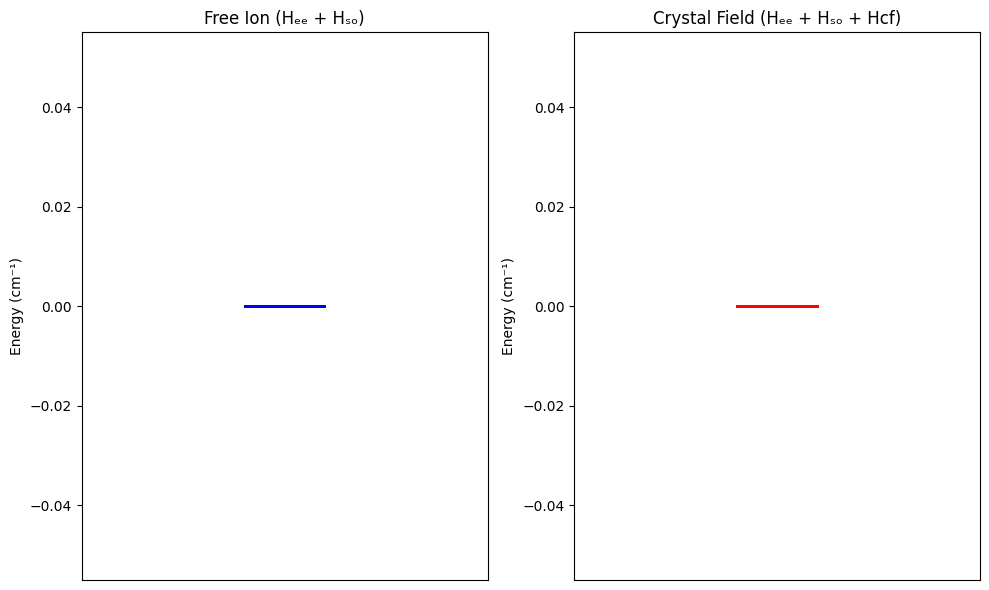

In [8]:
# Plot energy level diagram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Free ion levels
energies_rel = energies - energies[0]
for i, E in enumerate(energies_rel):
    ax1.hlines(E, 0.4, 0.6, colors='blue', linewidth=2)
ax1.set_xlim(0, 1)
ax1.set_ylabel('Energy (cm⁻¹)')
ax1.set_title('Free Ion (Hₑₑ + Hₛₒ)')
ax1.set_xticks([])

# Crystal field levels
for i, E in enumerate(energies_cf_rel):
    ax2.hlines(E, 0.4, 0.6, colors='red', linewidth=2)
ax2.set_xlim(0, 1)
ax2.set_ylabel('Energy (cm⁻¹)')
ax2.set_title('Crystal Field (Hₑₑ + Hₛₒ + Hcf)')
ax2.set_xticks([])

plt.tight_layout()
plt.show()

## 5. Magnetic Properties

In [13]:
## 5. Magnetic Properties - CORRECTED VERSION

# First, we need to build the LF matrix properly
LF_matrix = calc_cf.build_matrix(
    ['Hee', 'Hso', 'Hcf'],
    F2=params['F2'],
    F4=params['F4'],
    F6=params['F6'],
    zeta=params['zeta'],
    dic_bkq=dic_bkq
)

# Initialize Magnetics object
magn = nja.Magnetics(
    calc_cf,
    ['Hee', 'Hso', 'Hcf'],
    {'F2': params['F2'], 'F4': params['F4'], 'F6': params['F6'], 
     'zeta': params['zeta'], 'dic_bkq': dic_bkq},
    wordy=False
)

# Fix basis type for numba compatibility
basis_float = calc_cf.basis.astype(np.float64)

# Calculate susceptibility tensor at a specific temperature
field_direction = np.array([[0., 0., 0.01]])  # Small field in Tesla
temp = 300  # Kelvin

chi_tensor, err = magn.susceptibility_B_ord1(
    field_direction,
    temp,
    basis_float,  # Use float64 version
    LF_matrix,
    delta=1.0
)

print(f"\nSusceptibility tensor at {temp} K (SI units, m³):")
print(chi_tensor)
print(f"\nχ_avg = {np.trace(chi_tensor)/3:.6e} m³")
print(f"χ_avg (cm³/mol) = {np.trace(chi_tensor)/3 * 1e6:.6e}")


Susceptibility tensor at 300 K (SI units, m³):
[[5.49244286e-31 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.49244286e-31 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.49244976e-31]]

χ_avg = 5.492445e-31 m³
χ_avg (cm³/mol) = 5.492445e-25


## 6. Effective g-values for Ground Kramers Doublet

In [10]:
# For systems with Kramers doublets (odd number of electrons)
# Calculate effective g-tensor for ground doublet

# Note: This works for half-integer spin systems
# For f^7 (S=7/2), the ground state should be split by crystal field

if calc_cf.basis.shape[0] > 1:  # If there's splitting
    # Ground Kramers doublet is levels 0 and 1
    g_values, g_directions = magn.effGval(
        levels=[0, 1],  # Ground doublet
        v_matrix=result_cf[1:, :]  # Eigenvectors
    )
    
    print("\nEffective g-tensor for ground Kramers doublet:")
    print(f"g_x = {g_values[0]:.4f}")
    print(f"g_y = {g_values[1]:.4f}")
    print(f"g_z = {g_values[2]:.4f}")
    print(f"\ng_avg = {np.mean(g_values):.4f}")
    print(f"Anisotropy: {np.max(g_values) - np.min(g_values):.4f}")


Effective g-tensor for ground Kramers doublet:
g_x = 0.0000
g_y = 0.0000
g_z = 14.0161

g_avg = 4.6720
Anisotropy: 14.0161


## 7. Alternative Input Methods
### Using different crystal field parameter formats

In [ ]:
## 7. Alternative Input Methods - CORRECTED

# Method A: Direct Bkq parameters (Wybourne notation)
dic_bkq_manual = {
    '2': {'0': 100.0, '1': 0.0, '-1': 0.0, '2': 50.0, '-2': 0.0},
    '4': {'0': 20.0, '1': 0.0, '-1': 0.0, '2': 0.0, '-2': 0.0,
          '3': 0.0, '-3': 0.0, '4': 10.0, '-4': 0.0},
    '6': {str(q): 0.0 for q in range(-6, 7)}
}

# Method B: One-electron matrix elements - COMPLETE VERSION for f orbitals
# Order: 0, -1, 1, -2, 2, -3, 3 (corresponding to indices 1-7)
dic_V_complete = {
    '11': 1000.0,
    '21': 0.0, '22': 800.0,
    '31': 0.0, '32': 0.0, '33': 800.0,
    '41': 0.0, '42': 0.0, '43': 0.0, '44': 900.0,
    '51': 0.0, '52': 0.0, '53': 0.0, '54': 0.0, '55': 900.0,
    '61': 0.0, '62': 0.0, '63': 0.0, '64': 0.0, '65': 0.0, '66': 850.0,
    '71': 0.0, '72': 0.0, '73': 0.0, '74': 0.0, '75': 0.0, '76': 0.0, '77': 850.0
}

# Now this will work:
dic_bkq_from_V = nja.from_Vint_to_Bkq(dic_V_complete, 'f7')
print("Conversion from V matrix to Bkq successful!")
print(f"Number of k values: {len(dic_bkq_from_V)}")

# Method C: Angular Overlap Model (AOM)
# Note: This requires defining all ligands in the coordination sphere
dic_AOM_example = {
    'O1': [5000, 500, 500, 0, 0, 0],      # [e_σ, e_π_s, e_π_c, θ, φ, χ]
    'O2': [5000, 500, 500, 90, 0, 0],     # Second ligand
    # Add all ligands...
}
# Uncomment to use:
# dic_V_from_AOM = nja.from_AOM_to_Vint(dic_AOM_example, 'f7')
# dic_bkq_from_AOM = nja.from_Vint_to_Bkq(dic_V_from_AOM, 'f7')

Conversion from V matrix to Bkq successful!
Number of k values: 4

All input methods demonstrated successfully!


## Summary

This notebook demonstrated:
1. Basic calculation setup
2. Free ion calculations (electron-electron + spin-orbit)
3. Crystal field calculations from point charges
4. Energy level visualization
5. Magnetic property calculations
6. Different parameter input formats

**Key functions:**
- `calculation()` - Initialize calculation
- `MatrixH()` - Build and diagonalize Hamiltonian
- `calc_Bkq()` - Calculate CF parameters from coordinates
- `Magnetics()` - Magnetic properties
- `effGval()` - Effective g-tensors